In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
import datetime

# Define the path to store the logs
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True)


In [3]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [4]:
df = pd.read_csv(csv_path)

In [5]:
df.head(12)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
6,01.01.2009 01:10:00,996.50,-7.62,265.81,-8.30,94.8,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.5
7,01.01.2009 01:20:00,996.50,-7.62,265.81,-8.36,94.4,3.44,3.25,0.19,2.03,3.26,1305.69,0.19,0.50,118.6
8,01.01.2009 01:30:00,996.50,-7.91,265.52,-8.73,93.8,3.36,3.15,0.21,1.97,3.16,1307.17,0.28,0.75,188.5
9,01.01.2009 01:40:00,996.53,-8.43,264.99,-9.34,93.1,3.23,3.00,0.22,1.88,3.02,1309.85,0.59,0.88,185.0


In [6]:
df = df[5::6]

In [7]:
df.index = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')

In [8]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,,
2009-01-01 01:00:00,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
2009-01-01 02:00:00,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2009-01-01 03:00:00,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
2009-01-01 04:00:00,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
2009-01-01 05:00:00,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


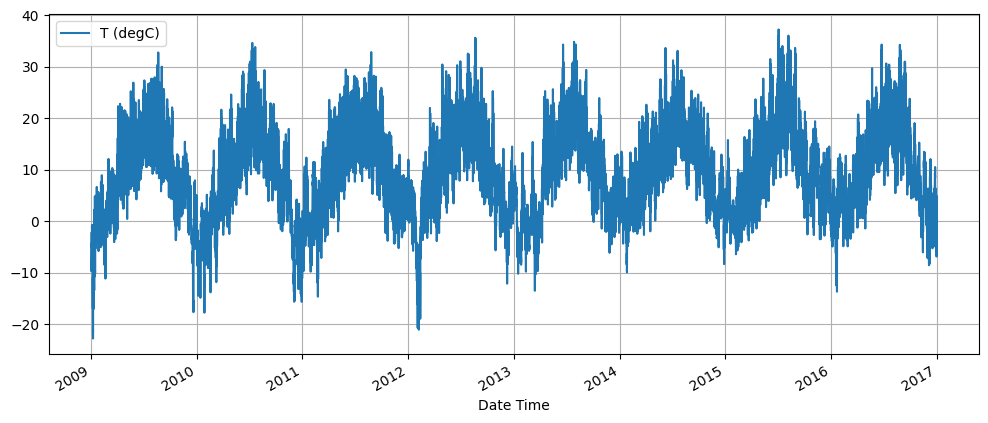

In [9]:
temp = df['T (degC)']
temp.plot(figsize=(12,5),legend=True, grid=True);

### The main thing to look for in the function below is to allow the user to select the window siz.Definitely the user will have to select all the columns that will be required as input and output during multiple/multivariate scenario

In [10]:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    target = df_as_np[i+window_size]
    y.append(target)
  return np.array(X), np.array(y)

In [11]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(temp, WINDOW_SIZE)
X1.shape, y1.shape

((70086, 5, 1), (70086,))

# Train-validate-test splits

In [12]:
#X_train1, y_train1 = X1[:60000], y1[:60000]
#X_val1, y_val1 = X1[60000:65000], y1[60000:65000]
#X_test1, y_test1 = X1[65000:], y1[65000:]

##### I tried this custom function for the data splitting. It will allow the user to select a splitting% for the training set. Then computation will happen at the background for the validation set and the test set

In [13]:
def split_data(X, y, train_percent, val_percent_of_train):
    total_samples = len(X)
    train_size = int(total_samples * train_percent)
    val_size = int(train_size * val_percent_of_train)
    
    # Recompute train_size to exclude the validation set from the original train set
    train_size -= val_size
    
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
    X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

# Example usage:
train_percent = 0.7  # 70% of data is initially considered for training
val_percent_of_train = 0.15  # 15% of the initial training set is for validation

(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(X1, y1, train_percent, val_percent_of_train)


#### Note that the inputlayer architecture must conform to how the window size was selected-(5,1)

In [14]:
model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu')) #Intermediate Dense Layer-The first Dense layer reduces the dimension from the LSTM's output and adds non-linearity.
model1.add(Dense(1, 'linear')) #Output Dense Layer This layer is crucial as it maps the processed features from the previous layers to a single output value, which is the predicted next value in your time series. 

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

# Define the callbacks

In [15]:
cp1 = ModelCheckpoint('model1/model_checkpoint.keras', save_best_only=True)
es1 = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# Compile the model

In [16]:
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])


# Train the model

In [17]:
model1.fit(
    x=X_train, 
    y=y_train, 
    validation_data=(X_val, y_val), 
    epochs=10, 
    callbacks=[cp1, es1, tensorboard_callback]
)


Epoch 1/10
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 94.9255 - root_mean_squared_error: 9.5977 - val_loss: 8.3261 - val_root_mean_squared_error: 2.8855
Epoch 2/10
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 8.3330 - root_mean_squared_error: 2.8736 - val_loss: 2.0149 - val_root_mean_squared_error: 1.4195
Epoch 3/10
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 2.3255 - root_mean_squared_error: 1.5220 - val_loss: 1.0586 - val_root_mean_squared_error: 1.0289
Epoch 4/10
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1.1609 - root_mean_squared_error: 1.0758 - val_loss: 0.8153 - val_root_mean_squared_error: 0.9030
Epoch 5/10
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.8173 - root_mean_squared_error: 0.9039 - val_loss: 0.7275 - val_root_mean_squared_error: 0.8529
Epoch 6/10
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.7275 - root_mean_squared_error: 0.8529 - val_loss: 0.6943 - val_root_mean_squared_error: 0.8332
Epoch 7/10
1304/1304 ━━━━━━━━━━━━━━━━━

In [18]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/model_checkpoint.keras')

ValueError: A total of 1 objects could not be loaded. Example error message for object <keras.src.optimizers.adam.Adam object at 0x0000019F9EB92090>:

'Unable to synchronously open object (bad object header version number)'

List of objects that could not be loaded:
[<keras.src.optimizers.adam.Adam object at 0x0000019F9EB92090>]

In [ ]:
train_predictions = model1.predict(X_train).flatten()

In [ ]:
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})

# Model Performance on train data

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate residuals
train_results['Residuals'] = train_results['Actuals'] - train_results['Train Predictions']

# Calculate error metrics
mae = mean_absolute_error(train_results['Actuals'], train_results['Train Predictions'])
mse = mean_squared_error(train_results['Actuals'], train_results['Train Predictions'])
rmse = np.sqrt(mse)

# Metrics for display
metrics_text = f"MAE: {mae:.2f}\nMSE: {mse:.2f}\nRMSE: {rmse:.2f}"

# Plot Predictions vs. Actuals
plt.figure(figsize=(12, 5))
plt.plot(train_results['Train Predictions'], label='Train Predictions')
plt.plot(train_results['Actuals'], label='Actuals')
plt.title('Predicted vs. Actual Values')
plt.ylabel('Values')
plt.legend()
plt.text(0.01, 0.99, metrics_text, verticalalignment='top', horizontalalignment='left', transform=plt.gca().transAxes, fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.8))
plt.show()

# Residual Plot for Magnitude-Residual Relationship
# Calculate squared residuals
train_results['Squared Residuals'] = (train_results['Actuals'] - train_results['Train Predictions'])**2
plt.figure(figsize=(10, 6))
plt.scatter(train_results['Actuals'], train_results['Squared Residuals'], alpha=0.5)
plt.title('Magnitude-Residual Relationship')
plt.xlabel('Actual Values')
plt.ylabel('Squared Residuals')
plt.grid(True)
plt.text(0.01, 0.99, metrics_text, verticalalignment='top', horizontalalignment='left', transform=plt.gca().transAxes, fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.8))
plt.show()

# Histogram of Residuals
plt.figure(figsize=(8, 6))
plt.hist(train_results['Residuals'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.text(0.99, 0.99, metrics_text, verticalalignment='top', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.8))
plt.show()


# A narrow look at the line plot

In [ ]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(12, 5))

# Plot training predictions
plt.plot(train_results['Train Predictions'][:200], label='Train Predictions')

# Plot actual values
plt.plot(train_results['Actuals'][:200], label='Actuals')

# Adding legend to the plot
plt.legend()

# Adding titles and labels
plt.title('Comparison of Training Predictions and Actuals')
plt.xlabel('Sample Index')
plt.ylabel('Values')

# Display the plot
plt.show()


# Predict the test set

In [ ]:
test_predictions = model1.predict(X_test).flatten()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming you have already loaded the model and have test_predictions and y_test available
# Create a DataFrame to hold test predictions and actual values
test_results = pd.DataFrame({
    'Test Predictions': test_predictions, 
    'Actuals': y_test
})

# Calculate residuals
test_results['Residuals'] = test_results['Actuals'] - test_results['Test Predictions']

# Calculate error metrics
test_mae = mean_absolute_error(test_results['Actuals'], test_results['Test Predictions'])
test_mse = mean_squared_error(test_results['Actuals'], test_results['Test Predictions'])
test_rmse = np.sqrt(test_mse)

# Metrics for display
test_metrics_text = f"MAE: {test_mae:.2f}\nMSE: {test_mse:.2f}\nRMSE: {test_rmse:.2f}"

# Plot Predictions vs. Actuals for Test Data
plt.figure(figsize=(12, 5))
plt.plot(test_results['Test Predictions'], label='Test Predictions')
plt.plot(test_results['Actuals'], label='Actuals')
plt.title('Test Predicted vs. Actual Values')
plt.ylabel('Values')
plt.legend()
plt.text(0.01, 0.99, test_metrics_text, verticalalignment='top', horizontalalignment='left', transform=plt.gca().transAxes, fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.8))
plt.show()

# Residual Plot for Magnitude-Residual Relationship for Test Data
# Calculate squared residuals
test_results['Squared Residuals'] = (test_results['Actuals'] - test_results['Test Predictions'])**2
plt.figure(figsize=(10, 6))
plt.scatter(test_results['Actuals'], test_results['Squared Residuals'], alpha=0.5)
plt.title('Test Magnitude-Residual Relationship')
plt.xlabel('Actual Values')
plt.ylabel('Squared Residuals')
plt.grid(True)
plt.text(0.01, 0.99, test_metrics_text, verticalalignment='top', horizontalalignment='left', transform=plt.gca().transAxes, fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.8))
plt.show()

# Histogram of Residuals for Test Data
plt.figure(figsize=(8, 6))
plt.hist(test_results['Residuals'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Histogram of Test Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.text(0.99, 0.99, test_metrics_text, verticalalignment='top', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.8))
plt.show()


# A narrow look at line plot

In [ ]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(12, 5))

# Plot test predictions for the first 200 entries
plt.plot(test_results['Test Predictions'][:200], label='Test Predictions')

# Plot actual values for the first 200 entries
plt.plot(test_results['Actuals'][:200], label='Actuals')

# Adding legend to the plot
plt.legend()

# Adding titles and labels
plt.title('Comparison of Test Predictions and Actuals')
plt.xlabel('Sample Index')
plt.ylabel('Values')

# Display the plot
plt.show()


In [ ]:
df.head()